<a href="https://colab.research.google.com/github/Mahshad-RM/MOR/blob/old/AssignmentDLROM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
try:
     from dlroms import*
except:
     !pip install --no-deps git+https://github.com/NicolaRFranco/dlroms.git
     from dlroms import*

import numpy as np

##<font color="#FFD700"> **Linear elasticity**: material design for a stunt training facility

In [48]:
# FOM discretization
mesh = fe.unitsquaremesh(40, 40)
Vh = fe.space(mesh, 'CG', 1, vector_valued = True)
clc()

####<font color= '#008080'>  Data Download and Load :

In [49]:
# Dataset (parameters and FOM simulations)
import gdown
gdown.download(id = "1XYPnIpVVc9jkd7LwMhC-FYoV2RTnTK8L", output = "floor.npz")
clc()

data = np.load("floor.npz")
mu, u = dv.tensor(data['mu'], data['u'])

In [50]:
# Auxiliary function for animation
def animated_warp(u, Vh):
  from dlroms.gifs import save as savegif
  rnd = np.random.randint(50000)
  def drawframe(i):
    plt.figure(figsize = (4, 4))
    fe.plot(u[i], Vh, axis = [-0.25, 1.25, -0.25, 1.25], warp = True)
    plt.title("t = %.2f" % (i*0.02))
    plt.axis("off")
  savegif(drawframe, len(u), "temp%d-gif" % rnd)
  from PIL import Image, ImageSequence
  path = "temp%d-gif.gif" % rnd
  with Image.open(path) as im:
    frames = [frame.copy() for frame in ImageSequence.Iterator(im)]
    frames[0].save(path, save_all=True, append_images=frames[1:], loop=0, duration=im.info.get('duration', 100))
  from IPython.display import Image, display
  display(Image("temp%d-gif.gif" % rnd))
  from os import remove
  remove("temp%d-gif.gif" % rnd)

In [51]:
# First simulation in the dataset
#animated_warp(u[0], Vh)

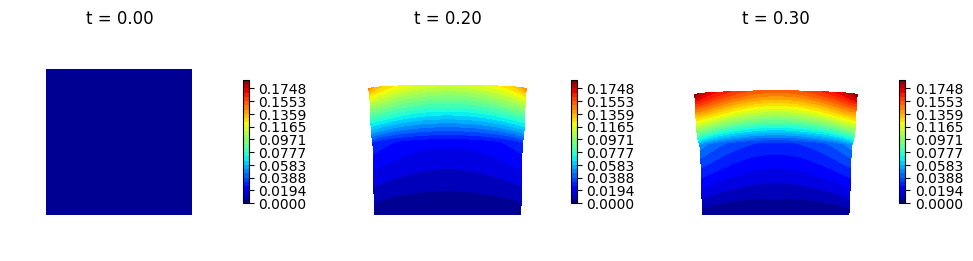

In [52]:
# Fancy plot showing warping and displacement magnitude altogether

which = 7 # First simulation

ns, nt, nh = u.shape
t = list(np.linspace(0, 1, nt))

umod = u[which].reshape(nt, -1, 2).pow(2).sum(axis = -1).sqrt()
plt.figure(figsize = (12, 4))
for i, ti in enumerate([0, 10, 15]):
  plt.subplot(1, 3, i+1)
  warped_mesh = fe.warpmesh(u[which, ti], Vh)
  delta = mu[which].item()
  WVh = fe.space(warped_mesh, 'CG', 1)

  fe.plot(umod[ti], WVh, levels = 30, vmin = umod.min(), vmax = umod.max(), colorbar = True, shrink = 0.4)
  plt.axis([-0.25, 1.25, -0.25, 1.25])
  plt.title("t = %.2f" % t[ti])
  plt.axis("off")

####<font color= '#008080'>  Data Dimensions Printed:

In [53]:
ndata, ntimes, nh = u.shape
p = mu.shape[-1]
print("Trajectories:\t%d." % ndata)
print("Timesteps:\t%d." % ntimes)
print("FOM dimension:\t%d." % nh)
print("Parameters:\t%d." % p)

Trajectories:	100.
Timesteps:	51.
FOM dimension:	3362.
Parameters:	1.


#### Data Description
100 full-order simulations with:
- 51 time snapshots ($t=0$ to $t=1$ with $\Delta t=0.02$)
- 3362 spatial DoFs per snapshot ($\in \mathbb{R}^{3362}$)




####<font color= '#008080'>  Time-Extended Parameter Tensor mut:

In [54]:
mut = dv.zeros(ndata, ntimes, p+1)
times = dv.tensor(np.linspace(0, 1, ntimes))
for i in range(ndata):
    mut[i,:,:p] = mu[i] # Corrected slice based on actual p
    mut[i,:, p] = times # Assign times to the correct index

Each time slice of a trajectory contains:

$$
[\mu_i, t_j]
$$
This is critical because ROM will likely use both parameter and time as input to predict displacement.

In [55]:
u = u.reshape(-1, nh)
u.shape

torch.Size([5100, 3362])

In [56]:
mut = mut.reshape(-1, p+1)
mut.shape

torch.Size([5100, 2])

In [57]:
l2 = L2(Vh)
clc()

def error(utrue, upred):
    return (l2(utrue-upred).reshape(-1, nt).sum(axis = -1)/l2(utrue).reshape(-1, nt).sum(axis = -1)).mean()


<mark>**DL-ROM**</mark></br>

# Recap of the DL-ROM Steps
Step | Description | Mapping
--- | --- | ------------------
**1. Autoencoder** | Learn a low-dimensional latent representation | $\mathbf{u}(x,t) \mapsto \text{encoder} \mapsto \boldsymbol{z}(t) \mapsto \text{decoder} \mapsto \mathbf{u}(x,t)$
**2. Regressor** | Learn how latent variables evolve with inputs | $(\mu, t) \mapsto \phi(\mu,t) \mapsto \boldsymbol{z}(t)$
**3. Final ROM** | Full DL-ROM: parameter-to-solution prediction | $(\mu, t) \mapsto \text{decoder}(\phi(\mu, t)) \approx \mathbf{u}(x,t)$

In [58]:
from torch.optim import Adam
ntrain= 75*ntimes

latent = 10  # good for starting

# Use nn.Sequential or custom DFNN class
encoder = Dense(nh, 200, gelu) + Dense(200, 100, gelu) + Dense(100, latent, None)
decoder = Dense(latent, 100, gelu) + Dense(100, 200, gelu) + Dense(200, nh, None)

autoencoder = DFNN(encoder + decoder)

autoencoder.He()

autoencoder.train(
    u, u,
    ntrain=ntrain,
    epochs=500,
    loss=mse(l2),
    optim=Adam,
    lr=1e-4,
    batchsize=64
)

autoencoder.freeze()

		Train		Test
Epoch 500:	5.69e-08	5.58e-08.

>> ETA: 4.10s.

Training complete. Elapsed time: 34 minutes 11.31 seconds.


In [59]:
print("Autoencoder MRE: %s" % num2p(error(u[ntrain:], autoencoder(u[ntrain:]))))

Autoencoder MRE: 1.29%


In [60]:
nu = encoder(u)

phi = DFNN(
    Dense(2, 32, gelu) +
    Dense(32, 32, gelu) +
    Dense(32, latent, activation=None))

phi.He()

phi.train(mut, nu, ntrain = ntrain, epochs = 500, loss = mse(euclidean))

phi.freeze()

		Train		Test
Epoch 500:	4.42e-04	4.86e-04.

>> ETA: 0.44s.

Training complete. Elapsed time: 3 minutes 39.69 seconds.


In [61]:
dlrom = lambda mt: decoder(phi(mt))
num2p(error(u[ntrain:], dlrom(mut[ntrain:])))

'2.87%'

In [62]:
# Reshape to (nsim, nt, nh)
u = u.reshape(ndata, ntimes, nh)

# Autoencoder Configuration Table

| Config | Encoder Layers | Decoder Layers | Latent Dim | Epochs | LR | Batch | Loss | Train Error | Test Error | MRE |
|---|---|---|---|---|---|---|---|---|---|---|
| 1 | 50→5 | 5→50→100→nh | 5 | 20 | 1e-3 | - | MSE (L2) | 2.61e-03 | 2.18e-03 | 5.52% |
| 2 | 100→50→5 | 5→50→100→nh | 5 | 20 | 1e-3 | - | MSE (L2) | 6.50e-03 | 5.86e-03 | 9.11% |
| 3 | 256→128→5 | 5→256→64→nh | 5 | 50 | 1e-3 | - | MSE (L2) | 5.08e-03 | 4.47e-03 | 7.70% |
| 4 | 200→100→5 | 5→100→200→nh | 5 | 500 | 1e-4 | 64 | MSE (L2) | 1.10e-07 | 1.07e-07 | 1.78% |
| **5 (BEST)** | **200→100→10** | **10→100→200→nh** | **10** | **500** | **1e-4** | **64** | **MSE (L2)** | **5.69e-08** | **5.58e-08** | **1.29%** |

#  DL-ROM Configuration Table

| Config | Phi Network Layers | Latent Dim | Epochs | Loss | Train Error | Test Error | MRE |
|---|---|---|---|---|---|---|---|
| 1 | 128→128→64→5 | 5 | 500 | MSE (L2) | 1.39e-04 | 1.40e-04 | 6.87% |
| 2 | 128→128→64→5 | 5 | 500 | MSE (L2) | 1.21e-04 | 1.20e-04 | 11.71% |
| 3 | 50→50→5 | 5 | 500 | MSE (L2) | 6.08e-04 | 7.29e-04 | 9.22% |
| 4 | 100→100→5 | 5 | 500 | MSE (L2) | 6.08e-04 | 7.29e-04 | 3.22% |
| **5 (BEST)** | **100→100→10** | **10** | **500** | **MSE (L2)** | **4.42e-04** | **4.86e-04** | **2.87%** |



<mark>**POD+Autoencoder ROM Construction**</mark></br>

The code below implements and trains a POD-enhanced Autoencoder (POD+AE) model to compress and reconstruct high-dimensional displacement trajectories. The approximation structure is:
$$
\mathbf{u} \approx \text{decoder}(\text{encoder}(\mathbf{u}))
$$
This is achieved through the following stages:

* **POD projection:** $\mathbf{u} \mapsto \mathbf{V}^T \mathbf{u}$, which reduces the original spatial dimension $N_h$ to a reduced order $n_r$
* **Autoencoder compression:** $\text{encoder} = \psi' \circ \mathbf{V}^T$, $\text{decoder} = \mathbf{V} \circ \psi$, where $\psi'$ and $\psi$ are small neural networks that map between the reduced POD space and a lower-dimensional latent space $n$
* **Latent regression:** A separate regressor $\phi(\mu, t)$ maps physical parameters (e.g., material thickness $\delta$, time $t$) directly to the latent space

By combining these steps, we obtain a DL-ROM that provides fast and accurate predictions of the displacement field for any given parameter-time input.

In [63]:
from scipy.linalg import svd
u = u.reshape(-1, nh)

nr = 50
V = dv.tensor(svd(u[:ntrain].T.cpu().numpy(), full_matrices = False)[0][:, :nr]) ### <--- POD basis for POD-AE
ur = u @ V

In [74]:
from torch import tanh
rho = lambda x: tanh(0.1*x) ### <-- smooth activation that bounds the dynamics within [-1,1]^n

latent = 10
small_encoder = (
    Dense(nr, 100, gelu) +
    Dense(100, 100, gelu) +
    Dense(100, latent, gelu)
)

small_decoder = (
    Dense(latent, 100, gelu) +
    Dense(100, 100, gelu) +
    Dense(100, nr, activation=None)
)

small_ae = DFNN(small_encoder + small_decoder) ### <--- inner AE module, combining the "small encoder" and "small decoder"

small_ae.unfreeze()
small_ae.He()

small_ae.train(ur, ur, loss = mse(euclidean), ntrain = ntrain, epochs = 700, lr = 1e-4)

small_ae.freeze()
from dlroms.dnns import Matrix

encoder = Matrix(V.T) + small_encoder
decoder = small_decoder + Matrix(V)
ae = encoder + decoder
print("Autoencoder MRE: %s" % num2p(error(u[ntrain:], ae(u[ntrain:]))))
print("Autoencoder MRE: %s" % num2p(error(u[:ntrain], ae(u[:ntrain]))))

		Train		Test
Epoch 700:	4.47e-03	4.15e-03.

>> ETA: 0.97s.

Training complete. Elapsed time: 11 minutes 18.98 seconds.
Autoencoder MRE: 7.21%
Autoencoder MRE: 7.41%


In [75]:
nu = encoder(u)
phi = DFNN(Dense(p + 1, 128, gelu) +
      Dense(128, 128, gelu) +
      Dense(128, 64, gelu) +
      Dense(64, latent, activation=None))
phi.He()
phi.train(mut, nu, ntrain = ntrain, epochs = 400, loss = mse(euclidean))
phi.freeze()
dlrom = lambda mt: decoder(phi(mt))
num2p(error(u[ntrain:], dlrom(mut[ntrain:])))

		Train		Test
Epoch 400:	1.12e-03	1.61e-03.

>> ETA: 0.71s.

Training complete. Elapsed time: 4 minutes 43.57 seconds.


'7.58%'

## Autoencoder Configurations

| Config ID | Layers | Latent Dim | Activation | Epochs | LR | Train Error | Test Error | Train MRE | Test MRE | Training Time | Notes |
|---|---|---|---|---|---|---|---|---|---|---|---|
| AE-1 | 100→200→100→5 | 5 | gelu | 700 | 1e-4 | 4.00e-03 | 3.53e-03 | 7.37% | 7.03% | 24m53s | Original deep config |
| AE-2 | 100→100→5 | 5 | gelu | 700 | 1e-4 | 9.62e-03 | 8.33e-03 | 11.39% | 10.66% | 10m55s | Simplified architecture |
| AE-3 | 100→100→10 | 10 | gelu | 700 | 1e-4 | 4.47e-03 | 4.15e-03 | 7.41% | 7.21% | 11m19s | Increased latent dim |

## DL-ROM Configurations

| Config ID | Layers | Latent Dim | Activation | Epochs | LR | Train Error | Test Error | MRE | Training Time | Notes |
|---|---|---|---|---|---|---|---|---|---|---|
| DL-1 | 16→5 | 5 | gelu/None | 400 | 1e-4 | 2.32e-03 | 2.12e-03 | 11.46% | 2m44s| Basic configuration |
| DL-2 | 50→5 | 5 | gelu/None | 400 | 1e-4 | 4.65e-03 | 4.48e-03 | 12.07% | 1m15s | Wider first layer |
| DL-3 | 128→128→64→10 | 10 | gelu/None | 400 | 1e-4 | 1.12e-03 | 1.61e-03 | 7.58% | 4m44s | Deeper network |

